# Lightcurve Generator

Generate BBH in AGN disk model lightcurves for a given event

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import seaborn as sns  
from astropy.time import Time
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.ticker import LogLocator, FuncFormatter
import pickle

import synphot
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
from astropy.modeling.physical_models import BlackBody  
from synphot.models import Empirical1D
from synphot import SourceSpectrum, SpectralElement, Observation
from synphot.models import BlackBodyNorm1D, Empirical1D
from synphot.units import PHOTLAM, FLAM
import matplotlib

import matplotlib.patches as patches


# S250328ae

In [29]:
# Define events with start times and observation MJD times
events = {
    "S250328ae": {
        "chirp_mass": 11.96 + 9.0 - 5.84 ,
        "total_mass": 28.93 + 22.4 - 14.23,
        "dL": 492.33,
        "start": '2025-03-28 00:00:00',
        "obs_mjd": [60763., 60764., 60771., 60790.],
        "pfs_obs_mjd": [60768.],
        "obs_depths": {
            "decam1": {"z": 21.4, "r": 22.7, "i": 22.1},
            "decam2": {"z": 21.9, "r": 22.8, "i": 22.5},
            "decam3": {"z": 21.0, "r": 21.3, "i": 21.2},
            "decam4": {"z": 21.6, "r": 22.3, "i": 22.1},
            "pfs1": {"blue": 21.3, "red": 21.3, "nir": 19.6}
        },
    }
}


In [30]:
event_total_mass = [events[key]["total_mass"] for key in events.keys()]
event_total_mass = np.array(event_total_mass)
event_total_mass

array([37.1])

Compute epochs wrt to event start date

In [31]:
# Compute epochs
all_epochs = {}
for event, data in events.items():
    start_time = Time(data["start"], format='iso')
    obs_times = Time(data["obs_mjd"], format='mjd')
    all_epochs[event] = (obs_times - start_time).to_value('day')

# Print results
epochs = []
for event, ep in all_epochs.items():
    epochs.append(ep)
    print(f"{event}: {ep}")

S250328ae: [ 1.  2.  9. 28.]


In [32]:
# obs depths
obs_depths = {}
for event, data in events.items():
    obs_depths[event] = data.get("obs_depths", {})
    print(f"{event}: {obs_depths[event]}")

S250328ae: {'decam1': {'z': 21.4, 'r': 22.7, 'i': 22.1}, 'decam2': {'z': 21.9, 'r': 22.8, 'i': 22.5}, 'decam3': {'z': 21.0, 'r': 21.3, 'i': 21.2}, 'decam4': {'z': 21.6, 'r': 22.3, 'i': 22.1}, 'pfs1': {'blue': 21.3, 'red': 21.3, 'nir': 19.6}}


In [33]:
epochs

[array([ 1.,  2.,  9., 28.])]

Model functions

In [34]:
def t_ram(M_BBH, kick_velocity):
    return 20 * (M_BBH / 100) * (kick_velocity / 200)**(-3) # there is another exp in terms of G, Mbbh and vk but this is correct too

def t_diff(M_SMBH, aspect_ratio, height, optical_depth):
    diffusion_time = (
        8
        * (optical_depth / 100)
        * ( height / (aspect_ratio * 0.01))
        * (aspect_ratio / 700)
        * (M_SMBH / 10**8)
    )
    return diffusion_time

def t_end(M_SMBH, kick_velocity, aspect_ratio, height, theta):
    time_end = (
        67 
        * (kick_velocity / 200)**(-1) 
        * (aspect_ratio / 700) 
        * (M_SMBH / 10**8) 
        * (height / (aspect_ratio * 0.01))
        * (1 / np.sin(theta / 60))
    )
    return time_end

def L_BHL(M_BBH , kick_velocity, density, radiative_efficiency):
    lumi = (
        2.5 * 10**45
        * (radiative_efficiency / 0.1)
        * (M_BBH / 100)**2
        * ((kick_velocity+50) / 200)**(-3)
        * (density / 10**(-10))
    )
    return lumi

def t_exit(height, mp_optical_depth, kick_velocity):
    return (height * np.sqrt(2 * np.log(mp_optical_depth))) / kick_velocity


## Calculations

Parameters:
- Kick Velocity (vk)
- Disk Density (rho)
- Height of the disk (height) 
- Merger Point Optical Depth (mp_optical_depth)
- Angle at which BH is kicked wrt disk plane (theta)
- Mass of SMBH 
- Radiative Efficiency

Fiducial Model:
- vk: variable
- rho0: variable
- height: 700rg * 0.01 (fixed for all cases later)
- mp_optical_depth: C*rho0
- theta: 60 deg (fixed for all cases later)
- radiative_efficiency (fixed)
- mSMBH (fixed)


Note: Most important parameters here are kick velocity and density as they play a role in start and peak of the signature. Other params mostly affect the aftermath of the peak.

In [35]:
# Define the parameters for the grid
# Main Parameters
vk_array = np.array([100, 200, 300, 400, 500, 600, 700, 800])
rho_array = np.logspace(-3, -12, num=10, base=10)

# Other parameters
aspect_ratio = 700
height_array = aspect_ratio * np.array([0.01]) #[0.001, 0.01, 0.1])

C = 10**12
#mp_optical_depth = C * rho_array

theta_array = np.array([60]) #[30, 45, 60, 75])

vk_grid, rho_grid = np.meshgrid(vk_array, rho_array, indexing='ij')

# Fixed parameters
radiative_efficiency = 0.1
mSMBH = 10**8

#vk_grid, rho_grid

(array([[100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
        [200, 200, 200, 200, 200, 200, 200, 200, 200, 200],
        [300, 300, 300, 300, 300, 300, 300, 300, 300, 300],
        [400, 400, 400, 400, 400, 400, 400, 400, 400, 400],
        [500, 500, 500, 500, 500, 500, 500, 500, 500, 500],
        [600, 600, 600, 600, 600, 600, 600, 600, 600, 600],
        [700, 700, 700, 700, 700, 700, 700, 700, 700, 700],
        [800, 800, 800, 800, 800, 800, 800, 800, 800, 800]]),
 array([[1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07, 1.e-08, 1.e-09, 1.e-10,
         1.e-11, 1.e-12],
        [1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07, 1.e-08, 1.e-09, 1.e-10,
         1.e-11, 1.e-12],
        [1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07, 1.e-08, 1.e-09, 1.e-10,
         1.e-11, 1.e-12],
        [1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07, 1.e-08, 1.e-09, 1.e-10,
         1.e-11, 1.e-12],
        [1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07, 1.e-08, 1.e-09, 1.e-10,
         1.e-11, 1.e-12],
        [1.e-03, 1.e-04

In [36]:
# Start times

sig_start_times = t_ram(event_total_mass, vk_grid)

peak_times = 2 * sig_start_times
peak_luminosities = L_BHL(event_total_mass, vk_grid, rho_grid, radiative_efficiency)

# End times
#exit_times = t_exit(height_grid, mp_optical_depth_grid, vk_grid)

#peak_times = np.where(peak_times > end_times, end_times, peak_times)
end_times = t_end(mSMBH, vk_grid, aspect_ratio, height_array[0], theta_array[0])

Lightcurves

In [37]:
# Define the light curve model
def gaussian_rise(rise_array, peak_lumi):
    t = rise_array 
    tg = rise_array[-1] - rise_array[0]
    t0 = rise_array[-1]
    return peak_lumi * np.exp(-((t - t0) ** 2) / (2 * tg ** 2))

def exponential_decay(fall_array, peak_lumi):
    t = fall_array 
    t0 = fall_array[0]
    te = fall_array[-1] - fall_array[0]
    return peak_lumi * np.exp(-(t - t0) / te)

def light_curve_model(times, peak_lumi):
    # Split the time array into rise and fall arrays
    rise_times = np.linspace(times[0], times[1], 100)
    fall_times = np.linspace(times[1], times[2], 100)

    rise_lumis = gaussian_rise(rise_times, peak_lumi)
    fall_lumis = exponential_decay(fall_times, peak_lumi)
    
    return rise_times, fall_times, rise_lumis, fall_lumis
    

Use solar magnitudes to obtain griz band mags

In [38]:
'''# Constants
L_sun = 3.828e33  # Solar luminosity in erg/s
M_sun = {"g": 5.12, "r": 4.64, "i": 4.53, "z": 4.50}  # Solar absolute magnitudes

# Extract distance for each event
dLs = np.array([events[key]["dL"] for key in events.keys()])  

# Function to convert luminosity to absolute magnitude
def luminosity_to_mag(L, band):
    return M_sun[band] - 2.5 * np.log10(L / L_sun)

# Function to convert absolute magnitude to apparent magnitude
def absolute_to_apparent_mag(M_band, d_L):
    return M_band + 5 * np.log10(d_L) + 25

def luminosity_to_apparant_mag(L, d_L, band):
    M_band = luminosity_to_mag(L, band)
    return absolute_to_apparent_mag(M_band, d_L)

L = np.array(peak_luminosities)  

# Compute magnitudes for each band
mags = {}

for band in ["g", "r", "i", "z"]:
    # Compute absolute magnitudes per event
    M_band = luminosity_to_mag(L, band)
    
    # Compute apparent magnitudes per event
    mags[band] = absolute_to_apparent_mag(M_band, dLs)

print("Apparent Magnitudes (griz bands):", mags)'''

'# Constants\nL_sun = 3.828e33  # Solar luminosity in erg/s\nM_sun = {"g": 5.12, "r": 4.64, "i": 4.53, "z": 4.50}  # Solar absolute magnitudes\n\n# Extract distance for each event\ndLs = np.array([events[key]["dL"] for key in events.keys()])  \n\n# Function to convert luminosity to absolute magnitude\ndef luminosity_to_mag(L, band):\n    return M_sun[band] - 2.5 * np.log10(L / L_sun)\n\n# Function to convert absolute magnitude to apparent magnitude\ndef absolute_to_apparent_mag(M_band, d_L):\n    return M_band + 5 * np.log10(d_L) + 25\n\ndef luminosity_to_apparant_mag(L, d_L, band):\n    M_band = luminosity_to_mag(L, band)\n    return absolute_to_apparent_mag(M_band, d_L)\n\nL = np.array(peak_luminosities)  \n\n# Compute magnitudes for each band\nmags = {}\n\nfor band in ["g", "r", "i", "z"]:\n    # Compute absolute magnitudes per event\n    M_band = luminosity_to_mag(L, band)\n    \n    # Compute apparent magnitudes per event\n    mags[band] = absolute_to_apparent_mag(M_band, dLs)\n\n

Use blackbody approximation for SED

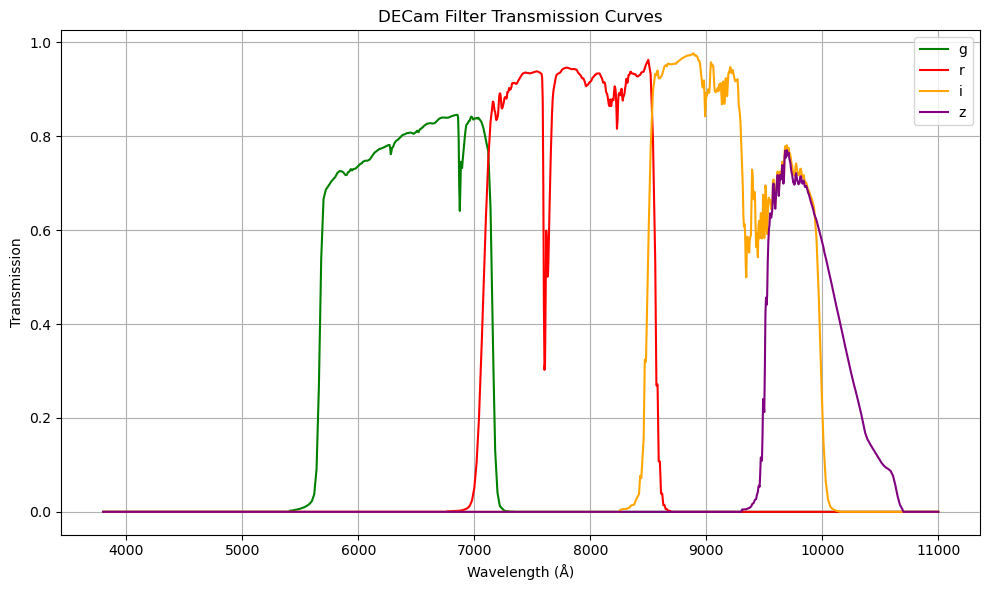

In [39]:
bandpasses = np.loadtxt('decam_transmission_curves.txt', skiprows=1)

wav = bandpasses[:,0] * u.AA  # Wavelengths in Angstroms
filter_g = bandpasses[:,2]
filter_r = bandpasses[:,3]
filter_i = bandpasses[:,4]
filter_z = bandpasses[:,5]

# Ensure wavelength is sorted
sort_idx = np.argsort(wav)
wav = wav[sort_idx]
filter_g = filter_g[sort_idx]
filter_r = filter_r[sort_idx]
filter_i = filter_i[sort_idx]
filter_z = filter_z[sort_idx]

area = np.pi * (2 * u.m) ** 2

# Plot the transmission curves
plt.figure(figsize=(10, 6))
plt.plot(wav, filter_g, label='g', color='green')
plt.plot(wav, filter_r, label='r', color='red')
plt.plot(wav, filter_i, label='i', color='orange')
plt.plot(wav, filter_z, label='z', color='purple')

plt.xlabel('Wavelength (Å)')
plt.ylabel('Transmission')
plt.title('DECam Filter Transmission Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
bp_g = SpectralElement(
    Empirical1D(points=wav.value, lookup_table=filter_g),
    wave_unit=wav.unit, throughput_unit=u.dimensionless_unscaled
)
bp_r = SpectralElement(
    Empirical1D(points=wav.value, lookup_table=filter_r),
    wave_unit=wav.unit, throughput_unit=u.dimensionless_unscaled
)
bp_i = SpectralElement(
    Empirical1D(points=wav.value, lookup_table=filter_i),
    wave_unit=wav.unit, throughput_unit=u.dimensionless_unscaled
)
bp_z = SpectralElement(
    Empirical1D(points=wav.value, lookup_table=filter_z),
    wave_unit=wav.unit, throughput_unit=u.dimensionless_unscaled
)
filters = {'g': bp_g, 'r': bp_r, 'i': bp_i, 'z': bp_z}

In [41]:
wav_grid = np.linspace(3000, 11000, 2000) * u.AA  # DECam wavelength range

In [42]:
def effective_temperature(kick_velocity):
    return 10**5 * (kick_velocity / 100)**2

For a given kick velocity, we have a flare temperature.

The radius of the flare can be calculated by using the relationship between luminosity of the backbody and temperature.

The luminosity varies as the flare evolves for the given kick velocity.

In [43]:
def compute_bb_mags(luminosities, kick_velocity, luminosity_distance):
    temperature = effective_temperature(kick_velocity)
    radius = np.sqrt(luminosities / (4 * np.pi * 5.67e-5 * temperature**4))  # in cm?
    radius = radius * u.cm.to(u.m) * u.m  # convert to meters
    #print(f'Radius: {radius}')
    redshift = z_at_value(cosmo.luminosity_distance, luminosity_distance)
    #print(f"Redshift for dL={luminosity_distance.to(u.Mpc):.2f} is z={redshift:.3f}")
    # ensure plain float
    redshift = float(redshift)
    factors = (radius.to(u.R_sun).value / luminosity_distance.to(u.kpc).value) ** 2
    #print(f'Factors: {factors.shape}')
    results = []

    for F in factors:
        sp_bb = SourceSpectrum(BlackBodyNorm1D, temperature=temperature) * F
        flux = sp_bb(wav_grid)  
        model = Empirical1D(points=wav_grid.value,     
                        lookup_table=flux.value)   
        sp_resampled = SourceSpectrum(model,
                                wave_unit=wav_grid.unit,   
                                flux_unit=flux.unit)
        mags = {}
        for band, bp in filters.items():
            obs = Observation(sp_resampled, bp)
            mags[band] = obs.effstim('abmag').value

        results.append({'Kick velocity (km/s)': kick_velocity, 'T_eff (K)': temperature, **mags})

    df = pd.DataFrame(results)
    #print(df)

    return df

In [44]:
def compute_bb_mags_fast(luminosities, kick_velocity, luminosity_distance):
    # 1) Compute temperature and radius
    #print(f'kick_velocity: {kick_velocity}')
    temperature = effective_temperature(kick_velocity)  # scalar
    #print(f'Temperature: {temperature}') ## 
    radius = np.sqrt(luminosities / (4 * np.pi * 5.67e-5 * temperature**4))  # in cm
    radius = radius * u.cm.to(u.m) * u.m
    redshift = float(z_at_value(cosmo.luminosity_distance, luminosity_distance))

    # scaling factors for apparent flux
    factors = (radius.to(u.R_sun).value / luminosity_distance.to(u.kpc).value) ** 2

    # 2) Evaluate blackbody flux once
    sp_bb = SourceSpectrum(BlackBodyNorm1D, temperature=temperature)
    flux_bb = sp_bb(wav_grid)  # PHOTLAM

    # 3) Vectorized flux scaling
    flux_scaled = flux_bb.value[None, :] * factors[:, None]  # shape: (N_events, N_wavelengths)
    N_events = flux_scaled.shape[0]

    results = []

    for i in range(N_events):
        # Wrap into SourceSpectrum for synphot once per event
        sp_resampled = SourceSpectrum(
            Empirical1D(points=wav_grid.value, lookup_table=flux_scaled[i]),
            wave_unit=wav_grid.unit,
            flux_unit=flux_bb.unit
        )

        mags = {}
        for band, bp in filters.items():
            obs = Observation(sp_resampled, bp)
            mags[band] = obs.effstim('abmag').value

        results.append({'Luminosities': luminosities[i], 'Kick velocity (km/s)': kick_velocity,
                        'T_eff (K)': temperature, **mags})

    return pd.DataFrame(results)

# Lightcurves

With customizations specifically for PFS-DESGW paper

In [45]:
# pfs epochs
pfs_epochs = {}
for event, data in events.items():
    if "pfs_obs_mjd" in data:  # check key exists
        start_time = Time(data["start"], format='iso')
        pfs_obs_times = Time(data["pfs_obs_mjd"], format='mjd')
        pfs_epochs[event] = (pfs_obs_times - start_time).to_value('day')

# Print results
pfs_epochs_list = []
for event, ep in pfs_epochs.items():
    pfs_epochs_list.append(ep)
    print(f"{event}: {ep}")

pfs_epochs_list , pfs_epochs

S250328ae: [6.]


([array([6.])], {'S250328ae': array([6.])})

In [46]:
values_decam = [
    {"z": 21.4, "r": 22.7, "i": 22.1},
    {"z": 21.9, "r": 22.8, "i": 22.5},
    {"z": 21.0, "r": 21.3, "i": 21.2},
    {"z": 21.6, "r": 22.3, "i": 22.1},
]
values_pfs = [
    {"blue": 21.3, "red": 21.3, "nir": 19.6}
]
obs_depths_decam = dict(zip(epochs[-1], values_decam))
obs_depths_pfs = dict(zip(pfs_epochs_list[-1], values_pfs))
print("DECam Depths:", obs_depths_decam)
print("PFS Depths:", obs_depths_pfs)

DECam Depths: {1.0: {'z': 21.4, 'r': 22.7, 'i': 22.1}, 2.0: {'z': 21.9, 'r': 22.8, 'i': 22.5}, 9.0: {'z': 21.0, 'r': 21.3, 'i': 21.2}, 28.0: {'z': 21.6, 'r': 22.3, 'i': 22.1}}
PFS Depths: {6.0: {'blue': 21.3, 'red': 21.3, 'nir': 19.6}}


In [47]:
dLs = np.array([events[key]["dL"] for key in events.keys()])  
dLs

array([492.33])

In [48]:
peak_times.shape, sig_start_times.shape, end_times.shape, peak_luminosities.shape

((8, 10), (8, 10), (8, 10), (8, 10))

# Caution: This cell can take a while (>~15min) to generate lightcurves. 

Skip this and directly load the pre-generated lightcurves pickle file in the next cell

In [49]:
'''%%time
for i, event in enumerate(events.keys()):
    model_dict = {}

    for a in range(len(vk_array)):
        for b in range(len(rho_array)):

            # ---------- Time and Luminosity Information ----------
            if peak_times[a, b] > end_times[a, b]: 
                peak_times[a, b] = end_times[a, b]

            times = np.array([
                sig_start_times[a, b],
                peak_times[a, b],
                end_times[a, b]
            ])
            #print("times:", times.shape)
            #print("peak_luminosities:", peak_luminosities[a,b].shape)

            t_rise, t_fall, lumi_rise, lumi_fall = light_curve_model(
                times, peak_luminosities[a, b]
            )

            #print(t_rise.shape, t_fall.shape, lumi_rise.shape, lumi_fall.shape)
            #print(a, b, vk_array[a], rho_array[b])
            # ---------- Conversion to magnitudes in each band ----------
            mag_rise_g = compute_bb_mags_fast(lumi_rise, vk_grid[a, b], dLs[i] * u.Mpc)['g'].to_numpy()
            mag_fall_g = compute_bb_mags_fast(lumi_fall, vk_grid[a, b], dLs[i] * u.Mpc)['g'].to_numpy()
            mag_rise_r = compute_bb_mags_fast(lumi_rise, vk_grid[a, b], dLs[i] * u.Mpc)['r'].to_numpy()
            mag_fall_r = compute_bb_mags_fast(lumi_fall, vk_grid[a, b], dLs[i] * u.Mpc)['r'].to_numpy()
            mag_rise_i = compute_bb_mags_fast(lumi_rise, vk_grid[a, b], dLs[i] * u.Mpc)['i'].to_numpy()
            mag_fall_i = compute_bb_mags_fast(lumi_fall, vk_grid[a, b], dLs[i] * u.Mpc)['i'].to_numpy()
            mag_rise_z = compute_bb_mags_fast(lumi_rise, vk_grid[a, b], dLs[i] * u.Mpc)['z'].to_numpy()
            mag_fall_z = compute_bb_mags_fast(lumi_fall, vk_grid[a, b], dLs[i] * u.Mpc)['z'].to_numpy()

            # ---------- Combine rise and fall parts ----------
            time_g = np.concatenate([t_rise, t_fall])
            mag_g = np.concatenate([mag_rise_g, mag_fall_g])
            time_r = np.concatenate([t_rise, t_fall])
            mag_r = np.concatenate([mag_rise_r, mag_fall_r])
            time_i = np.concatenate([t_rise, t_fall])
            mag_i = np.concatenate([mag_rise_i, mag_fall_i])
            time_z = np.concatenate([t_rise, t_fall])
            mag_z = np.concatenate([mag_rise_z, mag_fall_z])

            # ---------- Sort by time ----------
            idx_g = np.argsort(time_g)
            idx_r = np.argsort(time_r)
            idx_i = np.argsort(time_i)
            idx_z = np.argsort(time_z)

            # ---------- Save this model's data ----------

            def scientific_to_latex(val):
                """Convert float in scientific notation to LaTeX-friendly 10^x format."""
                exponent = int(np.floor(np.log10(abs(val))))
                base = val / 10**exponent
                # Round base if needed (often it's 1.0 so you can omit)
                if np.isclose(base, 1.0):
                    return f"10^{{{exponent}}}"
                else:
                    return f"{base:.1f} \\times 10^{{{exponent}}}"

            rho_val = rho_array[b]
            rho_str = scientific_to_latex(rho_val)
            model_id = (
                        f"$v_k={vk_array[a]}km/s$\n"
                        f"$\\rho={rho_str}g/cm^3$\n"
                    )

            model_dict[model_id] = {
                'g': (time_g[idx_g], mag_g[idx_g]),
                'r': (time_r[idx_r], mag_r[idx_r]),
                'i': (time_i[idx_i], mag_i[idx_i]),
                'z': (time_z[idx_z], mag_z[idx_z]),
                'params': {
                    'vk': vk_array[a],
                    'rho': rho_array[b],
                }
            }
    model_dict['event'] = event
    model_dict['start'] = events[event]["start"]
    model_dict['dL'] = events[event]["dL"]
    model_dict['chirp_mass'] = events[event]["chirp_mass"]

    # ---------- Save the full model dictionary ----------
    with open(f'model_lightcurves_dict_{event}.pkl', 'wb') as f:
        pickle.dump(model_dict, f)

    print(f"Saved model lightcurves for event {event} with {len(model_dict)} models.")'''

'%%time\nfor i, event in enumerate(events.keys()):\n    model_dict = {}\n\n    for a in range(len(vk_array)):\n        for b in range(len(rho_array)):\n\n            # ---------- Time and Luminosity Information ----------\n            if peak_times[a, b] > end_times[a, b]: \n                peak_times[a, b] = end_times[a, b]\n\n            times = np.array([\n                sig_start_times[a, b],\n                peak_times[a, b],\n                end_times[a, b]\n            ])\n            #print("times:", times.shape)\n            #print("peak_luminosities:", peak_luminosities[a,b].shape)\n\n            t_rise, t_fall, lumi_rise, lumi_fall = light_curve_model(\n                times, peak_luminosities[a, b]\n            )\n\n            #print(t_rise.shape, t_fall.shape, lumi_rise.shape, lumi_fall.shape)\n            #print(a, b, vk_array[a], rho_array[b])\n            # ---------- Conversion to magnitudes in each band ----------\n            mag_rise_g = compute_bb_mags_fast(lumi_

In [54]:
# Load one event's model dict
event = list(events.keys())[0]  
with open(f'model_lightcurves_dict_{event}.pkl', 'rb') as f:
    model_dict = pickle.load(f)

#model_dict

In [51]:
# Paramter space compared to obs depths
# Find brightest (minimum) magnitude in each band
bands = ['r','i','z']
brightest = {band: min(d[band] for d in values_decam) for band in bands}

print(brightest)


{'r': 21.3, 'i': 21.2, 'z': 21.0}


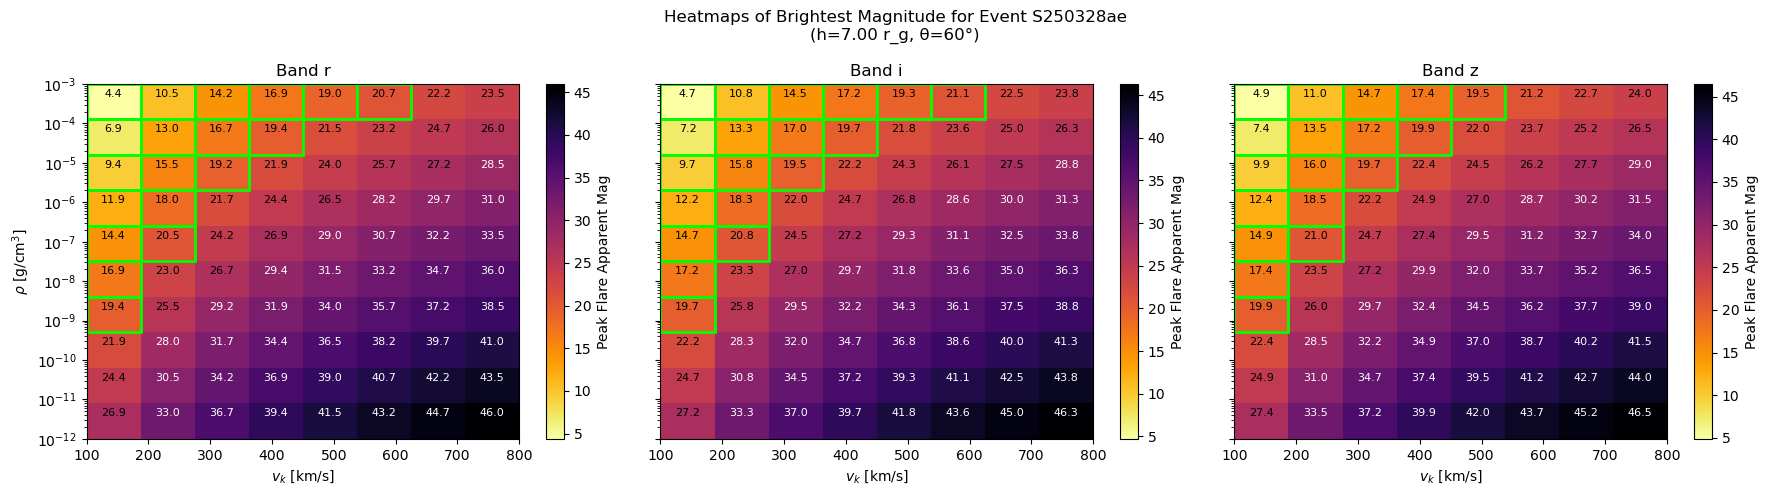

In [52]:
# filter models as needed
filtered_models = {m: model_dict[m] for m in model_dict 
                   if m not in ['event','start','dL','chirp_mass']}

vk_vals = np.array(sorted(set([filtered_models[m]['params']['vk'] for m in filtered_models])))
rho_vals = np.array(sorted(set([filtered_models[m]['params']['rho'] for m in filtered_models])))

heatmaps = {band: np.full((len(rho_vals), len(vk_vals)), np.nan) for band in bands}

for model_id, data in filtered_models.items():
    vk = data['params']['vk']
    rho = data['params']['rho']
    a = np.where(vk_vals == vk)[0][0]
    b = np.where(rho_vals == rho)[0][0]
    for band in bands:
        times, mags = data[band]
        heatmaps[band][b,a] = np.nanmin(mags)  # take brightest (lowest mag)


fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)

for i, band in enumerate(bands):
    vk_edges = np.linspace(vk_vals.min(), vk_vals.max(), len(vk_vals)+1)
    rho_edges = np.logspace(np.log10(rho_vals.min()), np.log10(rho_vals.max()), len(rho_vals)+1)
    vk_grid, rho_grid = np.meshgrid(vk_edges, rho_edges)

    pcm = axes[i].pcolormesh(
        vk_grid, rho_grid, heatmaps[band],
        cmap='inferno_r', shading='auto'
    )
    
    axes[i].set_title(f'Band {band}')
    axes[i].set_xlabel(r'$v_k$ [km/s]')
    axes[i].set_yscale('log')
    if i == 0:
        axes[i].set_ylabel(r'$\rho$ [g/cm$^3$]')

    fig.colorbar(pcm, ax=axes[i], label='Peak Flare Apparent Mag')

    for row_idx in range(len(rho_vals)):
        for col_idx in range(len(vk_vals)):
            val = heatmaps[band][row_idx, col_idx]
            if np.isnan(val):
                continue
            x = (vk_edges[col_idx] + vk_edges[col_idx+1]) / 2
            y = (rho_edges[row_idx] + rho_edges[row_idx+1]) / 2
            # Text annotation
            color = 'black' if val < np.nanmedian(heatmaps[band]) else 'white'
            axes[i].text(x, y, f'{val:.1f}', ha='center', va='center', color=color, fontsize=8)
            
            if val < brightest[band]:
                rect = patches.Rectangle(
                    (vk_edges[col_idx], rho_edges[row_idx]),
                    vk_edges[col_idx+1] - vk_edges[col_idx],
                    rho_edges[row_idx+1] - rho_edges[row_idx],
                    linewidth=2, edgecolor='lime', facecolor='none'
                )
                axes[i].add_patch(rect)

plt.suptitle(f'Heatmaps of Brightest Magnitude for Event {event}\n(h=7.00 r_g, θ=60°)')
plt.tight_layout()
plt.show()

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_58507/2042397236.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('inferno_r').copy()


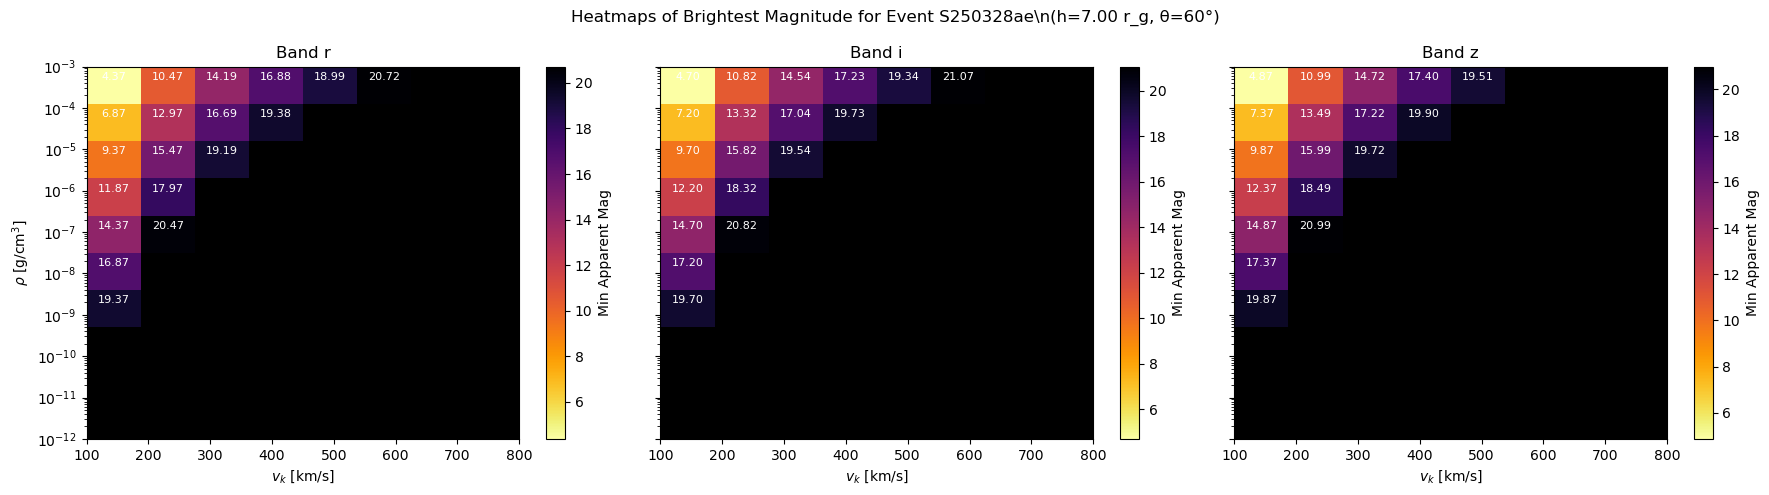

In [53]:
# filter models
filtered_models = {m: model_dict[m] for m in model_dict 
                   if m not in ['event','start','dL','chirp_mass']}

vk_vals = np.array(sorted(set([filtered_models[m]['params']['vk'] for m in filtered_models])))
rho_vals = np.array(sorted(set([filtered_models[m]['params']['rho'] for m in filtered_models])))

heatmaps = {band: np.full((len(rho_vals), len(vk_vals)), np.nan) for band in bands}

for model_id, data in filtered_models.items():
    vk = data['params']['vk']
    rho = data['params']['rho']
    a = np.where(vk_vals == vk)[0][0]
    b = np.where(rho_vals == rho)[0][0]
    for band in bands:
        times, mags = data[band]
        heatmaps[band][b,a] = np.nanmin(mags)  # take brightest (lowest mag)


masked_heatmaps = {}
for band in bands:
    arr = heatmaps[band]
    masked_heatmaps[band] = np.ma.masked_where(arr > brightest[band], arr)

cmap = matplotlib.cm.get_cmap('inferno_r').copy()
cmap.set_bad('black')

fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)

for i, band in enumerate(bands):
    vk_edges = np.linspace(vk_vals.min(), vk_vals.max(), len(vk_vals)+1)
    rho_edges = np.logspace(np.log10(rho_vals.min()), np.log10(rho_vals.max()), len(rho_vals)+1)
    vk_grid, rho_grid = np.meshgrid(vk_edges, rho_edges)
    pcm = axes[i].pcolormesh(
        vk_grid, rho_grid, masked_heatmaps[band],
        cmap=cmap, shading='auto'
    )
    axes[i].set_title(f'Band {band}')
    axes[i].set_xlabel(r'$v_k$ [km/s]')
    axes[i].set_yscale('log')
    if i == 0:
        axes[i].set_ylabel(r'$\rho$ [g/cm$^3$]')
    fig.colorbar(pcm, ax=axes[i], label='Min Apparent Mag')

    arr = masked_heatmaps[band]
    for b in range(arr.shape[0]):
        for a in range(arr.shape[1]):
            mag_value = arr[b, a]
            if not np.ma.is_masked(mag_value) and not np.isnan(mag_value):
                vk_center = (vk_edges[a] + vk_edges[a+1]) / 2
                rho_center = (rho_edges[b] + rho_edges[b+1]) / 2
                axes[i].text(vk_center, rho_center, f"{mag_value:.2f}",
                             ha='center', va='center', fontsize=8, color='white')

plt.suptitle(f'Heatmaps of Brightest Magnitude for Event {event}\\n(h=7.00 r_g, θ=60°)')
plt.tight_layout()
plt.show()


